In [1]:
import pickle
import numpy as np

In [2]:
with open("train_qa.txt", "rb") as f:
    train_data = pickle.load(f)

In [3]:
with open("test_qa.txt", "rb") as f:
    test_data = pickle.load(f)

In [4]:
type(train_data)

list

In [5]:
len(train_data)

10000

In [6]:
len(test_data)

1000

In [8]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [9]:
all_data = test_data + train_data

In [10]:
len(all_data)

11000

In [11]:
vocab = set()
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [12]:
vocab.add("no")
vocab.add("yes")

In [13]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [14]:
vocab_len = len(vocab) + 1

In [16]:
vocab_len

38

In [20]:
all_story_len = [len(data[0]) for data in all_data]

In [22]:
max_story_len = max(all_story_len)

In [23]:
max_question_len = max([len(data[1]) for data in all_data])

In [24]:
max_question_len

6

In [25]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [26]:
tokenizer = Tokenizer(filters = [])

In [27]:
tokenizer.fit_on_texts(vocab)

In [28]:
tokenizer.word_index

{'put': 1,
 'left': 2,
 'bathroom': 3,
 'took': 4,
 'is': 5,
 'back': 6,
 'bedroom': 7,
 'journeyed': 8,
 'discarded': 9,
 'john': 10,
 'hallway': 11,
 'down': 12,
 'travelled': 13,
 'there': 14,
 'daniel': 15,
 'kitchen': 16,
 'dropped': 17,
 'apple': 18,
 'got': 19,
 '?': 20,
 'picked': 21,
 'the': 22,
 'yes': 23,
 'football': 24,
 'to': 25,
 '.': 26,
 'up': 27,
 'moved': 28,
 'went': 29,
 'grabbed': 30,
 'in': 31,
 'milk': 32,
 'sandra': 33,
 'office': 34,
 'no': 35,
 'garden': 36,
 'mary': 37}

In [29]:
train_story_text = []
train_question_text = []
train_answers = []

In [30]:
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [31]:
train_story_sequence = tokenizer.texts_to_sequences(train_story_text)
# train_question_sequence = tokenizer.texts_to_sequences(train_question_text)

In [34]:
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len = max_question_len):
    x = []
    xq = []
    y = []
    for story, question, answer in data:
        x_temp = [word_index[word.lower()] for word in story]
        xq_temp = [word_index[word.lower()] for word in question]        
        y_temp = np.zeros(len(word_index)+1)
        y_temp[word_index[answer]] = 1
        x.append(x_temp)
        xq.append(xq_temp)        
        y.append(y_temp)
    return (pad_sequences(x,maxlen = max_story_len),pad_sequences(xq,maxlen = max_question_len), np.array(y))

In [35]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [36]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [37]:
from keras.models import Sequential, Model

In [38]:
from keras.layers.embeddings import Embedding

In [39]:
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [40]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [41]:
vocab_size = len(vocab)+1

In [42]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))


In [43]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [44]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [45]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [46]:
match = dot([input_encoded_m, question_encoded], axes = (2,2))

In [47]:
match = Activation("softmax")(match)

In [48]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

In [49]:
answer = concatenate([response, question_encoded])

In [50]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 6, 220) dtype=float32>

In [51]:
answer = LSTM(32)(answer)

In [52]:
answer = Dropout(0.5)(answer)

In [53]:
answer = Dense(vocab_size)(answer)

In [54]:
answer = Activation("softmax")(answer)

In [55]:
model = Model([input_sequence, question], answer)

In [56]:
model.compile(optimizer="rmsprop", loss = "categorical_crossentropy", metrics=["accuracy"])

In [57]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [58]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs = 200, validation_data=([inputs_test, queries_test], answers_test))

C:\Users\vikra\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 1000 samples
Epoch 1/200
10000/10000 [==============================] - 4s 403us/step - loss: 0.9230 - accuracy: 0.5034 - val_loss: 0.6967 - val_accuracy: 0.5030
Epoch 2/200
10000/10000 [==============================] - 3s 303us/step - loss: 0.7051 - accuracy: 0.5024 - val_loss: 0.6939 - val_accuracy: 0.4970
Epoch 3/200
10000/10000 [==============================] - 3s 301us/step - loss: 0.6961 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 4/200
10000/10000 [==============================] - 3s 334us/step - loss: 0.6950 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 5/200
10000/10000 [==============================] - 4s 362us/step - loss: 0.6938 - accuracy: 0.4994 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 6/200
10000/10000 [==============================] - 3s 327us/step - loss: 0.6951 - accuracy: 0.4967 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 7/200
10000/10000 [==============================] 

10000/10000 [==============================] - 3s 307us/step - loss: 0.2764 - accuracy: 0.8736 - val_loss: 0.3538 - val_accuracy: 0.8400
Epoch 56/200
10000/10000 [==============================] - 3s 303us/step - loss: 0.2749 - accuracy: 0.8729 - val_loss: 0.3417 - val_accuracy: 0.8400
Epoch 57/200
10000/10000 [==============================] - 3s 302us/step - loss: 0.2733 - accuracy: 0.8743 - val_loss: 0.3462 - val_accuracy: 0.8350
Epoch 58/200
10000/10000 [==============================] - 3s 305us/step - loss: 0.2726 - accuracy: 0.8771 - val_loss: 0.3534 - val_accuracy: 0.8310
Epoch 59/200
10000/10000 [==============================] - 3s 304us/step - loss: 0.2662 - accuracy: 0.8799 - val_loss: 0.3624 - val_accuracy: 0.8340
Epoch 60/200
10000/10000 [==============================] - 3s 306us/step - loss: 0.2721 - accuracy: 0.8759 - val_loss: 0.3643 - val_accuracy: 0.8330
Epoch 61/200
10000/10000 [==============================] - 3s 306us/step - loss: 0.2712 - accuracy: 0.8787 - val

10000/10000 [==============================] - 3s 303us/step - loss: 0.2206 - accuracy: 0.9009 - val_loss: 0.4761 - val_accuracy: 0.8390
Epoch 110/200
10000/10000 [==============================] - 3s 302us/step - loss: 0.2213 - accuracy: 0.9016 - val_loss: 0.4499 - val_accuracy: 0.8300
Epoch 111/200
10000/10000 [==============================] - 3s 301us/step - loss: 0.2220 - accuracy: 0.9022 - val_loss: 0.4890 - val_accuracy: 0.8280
Epoch 112/200
10000/10000 [==============================] - 3s 300us/step - loss: 0.2194 - accuracy: 0.9049 - val_loss: 0.4686 - val_accuracy: 0.8230
Epoch 113/200
10000/10000 [==============================] - 3s 307us/step - loss: 0.2187 - accuracy: 0.9024 - val_loss: 0.4945 - val_accuracy: 0.8320
Epoch 114/200
10000/10000 [==============================] - 3s 303us/step - loss: 0.2160 - accuracy: 0.9045 - val_loss: 0.5111 - val_accuracy: 0.8340
Epoch 115/200
10000/10000 [==============================] - 3s 308us/step - loss: 0.2190 - accuracy: 0.9059

10000/10000 [==============================] - 3s 300us/step - loss: 0.1745 - accuracy: 0.9286 - val_loss: 0.6031 - val_accuracy: 0.8320
Epoch 164/200
10000/10000 [==============================] - 3s 293us/step - loss: 0.1748 - accuracy: 0.9269 - val_loss: 0.6042 - val_accuracy: 0.8220
Epoch 165/200
10000/10000 [==============================] - 3s 297us/step - loss: 0.1776 - accuracy: 0.9270 - val_loss: 0.6086 - val_accuracy: 0.8270
Epoch 166/200
10000/10000 [==============================] - 3s 299us/step - loss: 0.1710 - accuracy: 0.9288 - val_loss: 0.6412 - val_accuracy: 0.8280
Epoch 167/200
10000/10000 [==============================] - 3s 295us/step - loss: 0.1676 - accuracy: 0.9290 - val_loss: 0.5976 - val_accuracy: 0.8200
Epoch 168/200
10000/10000 [==============================] - 3s 298us/step - loss: 0.1730 - accuracy: 0.9281 - val_loss: 0.5815 - val_accuracy: 0.8330
Epoch 169/200
10000/10000 [==============================] - 3s 300us/step - loss: 0.1704 - accuracy: 0.9291

In [59]:
filename = "chatbot.h5"
model.save(filename)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


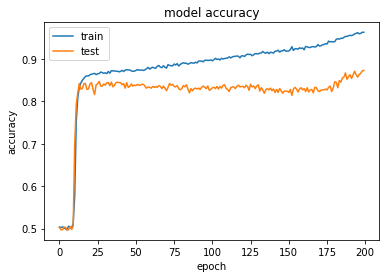

In [64]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
pred_results = model.predict(([inputs_test, queries_test]))

In [66]:
pred_results

array([[1.9736185e-15, 1.7839410e-15, 2.1506455e-15, ..., 9.9999416e-01,
        2.0767147e-15, 1.9369223e-15],
       [2.0673067e-16, 1.8996598e-16, 2.4513192e-16, ..., 9.9999750e-01,
        2.2071269e-16, 2.0610547e-16],
       [4.4020933e-12, 4.5647236e-12, 4.5311879e-12, ..., 9.2892252e-02,
        4.0999322e-12, 3.9836255e-12],
       ...,
       [1.6800756e-17, 1.6208368e-17, 2.0859326e-17, ..., 9.9999905e-01,
        1.7694034e-17, 1.6881896e-17],
       [2.7998546e-18, 1.7745235e-18, 2.5474884e-18, ..., 1.0147299e-05,
        1.9701616e-18, 1.7660685e-18],
       [1.8547856e-16, 2.3862297e-16, 2.3824914e-16, ..., 9.9988019e-01,
        2.3290508e-16, 2.3590140e-16]], dtype=float32)

In [68]:
pred_results[0]

array([1.9736185e-15, 1.7839410e-15, 2.1506455e-15, 2.1595897e-15,
       2.1324603e-15, 1.6814412e-15, 1.9469525e-15, 1.9015468e-15,
       2.0342957e-15, 2.4605591e-15, 1.7642742e-15, 1.7650146e-15,
       2.1815319e-15, 1.8560950e-15, 2.0655589e-15, 2.1137680e-15,
       1.6580905e-15, 2.1186278e-15, 2.3023291e-15, 1.5979313e-15,
       1.8410467e-15, 1.9705114e-15, 2.0871980e-15, 5.8121541e-06,
       1.7917294e-15, 1.8886067e-15, 1.5899416e-15, 1.6329385e-15,
       1.7963282e-15, 1.9750343e-15, 2.0749489e-15, 2.1716345e-15,
       1.9070093e-15, 2.0780143e-15, 1.9948422e-15, 9.9999416e-01,
       2.0767147e-15, 1.9369223e-15], dtype=float32)

In [69]:
val_max = np.argmax(pred_results[0])

In [70]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [71]:
test_data[0][1]

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [73]:
test_data[0][2]

'no'

In [74]:
for key, val in tokenizer.word_index.items():
    if val==val_max:
        k = key

In [75]:
k

'no'

In [76]:
pred_results[0][val_max]

0.99999416

In [77]:
my_story = "John left the kitchen . Sandra dropped football in the garden ."

In [78]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [79]:
my_question = "Is the football in the garden ?"

In [80]:
mydata = [(my_story.split(), my_question.split(), "yes")]

In [81]:
mydata


[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [82]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [83]:
ans = model.predict(([my_story, my_ques]))

In [84]:
ans

array([[1.50342842e-16, 9.35506862e-17, 1.30192802e-16, 1.15647989e-16,
        1.38216256e-16, 1.37186687e-16, 1.02242528e-16, 1.12935829e-16,
        1.31055346e-16, 1.08706733e-16, 1.46680973e-16, 1.21368320e-16,
        1.04892974e-16, 1.13387788e-16, 1.32678606e-16, 1.12469789e-16,
        1.05696305e-16, 1.87799725e-16, 1.05912642e-16, 1.44303934e-16,
        1.15982435e-16, 1.05766483e-16, 1.17526999e-16, 9.99957442e-01,
        1.51788106e-16, 1.09038154e-16, 1.56417114e-16, 1.10293589e-16,
        1.25551948e-16, 1.10339455e-16, 1.41719200e-16, 1.14719125e-16,
        1.53882871e-16, 1.13192454e-16, 1.35765922e-16, 4.25660437e-05,
        1.08632942e-16, 9.24385717e-17]], dtype=float32)

In [85]:
np.argmax(ans)

23

In [90]:
ans[0][23]

0.99995744

In [91]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}